In [ ]:
#| include: false
#all_slow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/_12_fastai.seg_unet_xresnext34.ipynb)

In [ ]:
#| include: false 
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.all import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [ ]:
fastai.__version__

'2.3.0'

In [ ]:
torch.__version__

'1.7.1+cu101'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat Apr 10 15:11:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   28C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print_competition_data(models_dir)

../models/fastai-UNET-ResNet34-256-stage5.pth
../models/resnet18_class.pth
../models/fastai-UNET-XResNeXt34-128x800.pth
../models/fastai-UNET-XResNeXt34-128x800-finetuning.pth
../models/.ipynb_checkpoints
../models/ResNet18-stage1-f1_0918.pth
../models/kaggle-UNET-ResNet34.pth
../models/ResNet18-encoder.pt
../models/kaggle-FPN-ResNet34.pth


In [ ]:
arch = xse_resnext34

In [ ]:
seg_metrics = [DiceMulti(), KaggleDice()]

## Small size

In [ ]:
bs = 8 # 16 gb
# dls = get_segmentation_dls(bs, size=(128, 800))

In [ ]:
dls = get_segmnt_dls(bs, size=(128, 800))

In [ ]:
cbs = [
    ShowGraphCallback(), 
    GradientAccumulation(n_acc=32),
    ReduceLROnPlateau(patience=2)
]
segmentation_learner = unet_learner(
    dls=dls, 
    arch=arch, 
    metrics=seg_metrics, 
    pretrained=True, 
    cbs=cbs,
    model_dir=models_dir
).to_fp16()

In [ ]:
# reloading state_dict
segmentation_learner = segmentation_learner.load("fastai-UNET-XResNeXt34-128x800")
# segmentation_learner.validate()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


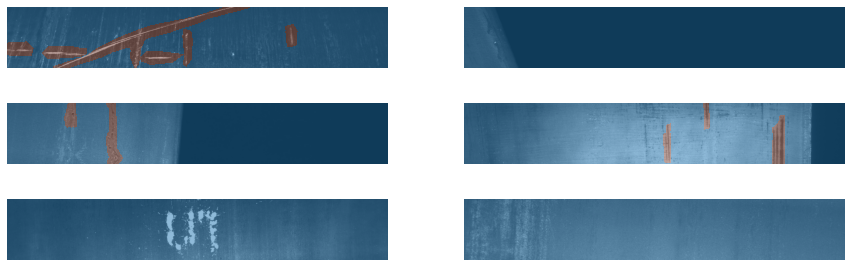

In [ ]:
segmentation_learner.dls.show_batch(figsize=(15,5), ncols=2)

In [ ]:
segmentation_learner.summary()

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 64 x 400  
Conv2d                                    864        False     
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 400  
Conv2d                                    18432      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 12

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=4.365158383734524e-05)

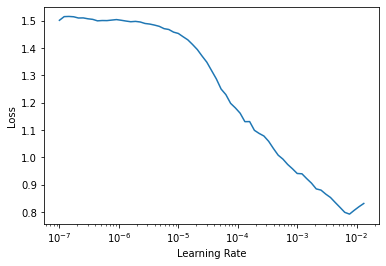

In [ ]:
segmentation_learner.lr_find()

epoch,train_loss,valid_loss,dice_multi,time
0,0.123493,0.123763,0.248825,12:28
1,0.110371,0.118004,0.241562,12:28
2,0.112678,0.110167,0.251399,12:28
3,0.100330,0.102569,0.265920,12:28
4,0.094040,0.089146,0.305323,12:27
5,0.090142,0.084011,0.365358,12:27
6,0.082269,0.085229,0.352996,12:26
7,0.084879,0.082785,0.373287,12:28
8,0.080693,0.073517,0.400721,12:27
9,0.070520,0.071543,0.431810,12:27


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


Better model found at epoch 0 with valid_loss value: 0.12376271933317184.


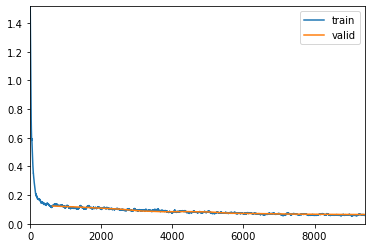

Better model found at epoch 1 with valid_loss value: 0.11800381541252136.
Better model found at epoch 2 with valid_loss value: 0.11016674339771271.
Better model found at epoch 3 with valid_loss value: 0.1025685966014862.
Better model found at epoch 4 with valid_loss value: 0.08914550393819809.
Better model found at epoch 5 with valid_loss value: 0.08401143550872803.
Better model found at epoch 7 with valid_loss value: 0.0827852115035057.
Better model found at epoch 8 with valid_loss value: 0.073516845703125.
Better model found at epoch 9 with valid_loss value: 0.07154327630996704.
Better model found at epoch 10 with valid_loss value: 0.06962405145168304.
Better model found at epoch 11 with valid_loss value: 0.06719432026147842.
Better model found at epoch 12 with valid_loss value: 0.06623176485300064.
Better model found at epoch 13 with valid_loss value: 0.06516284495592117.
Better model found at epoch 14 with valid_loss value: 0.06496747583150864.


In [ ]:
segmentation_learner.fit_one_cycle(15, lr_max=3e-4)

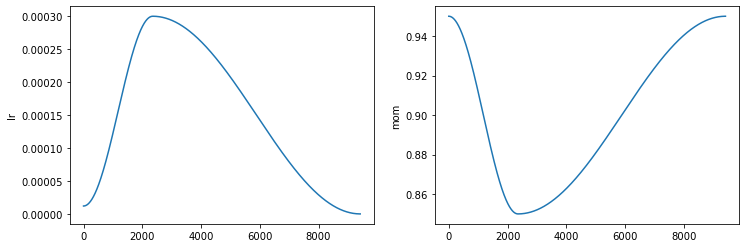

In [ ]:
segmentation_learner.recorder.plot_sched()

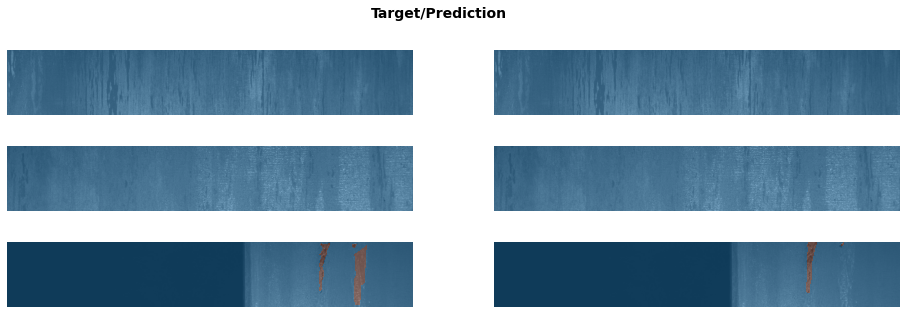

In [ ]:
segmentation_learner.show_results(ds_idx=1, figsize=(16,5))

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.007585775572806597)

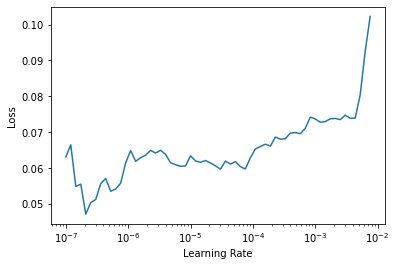

In [ ]:
segmentation_learner.unfreeze()
segmentation_learner.lr_find()

epoch,train_loss,valid_loss,dice_multi,time
0,0.058098,0.066120,0.456582,13:41
1,0.061666,0.066386,0.439961,13:41
2,0.069486,0.067866,0.439829,13:40
3,0.062465,0.067259,0.428582,13:40
4,0.063312,0.069750,0.441321,13:41
5,0.064017,0.066123,0.452684,13:41
6,0.062327,0.067325,0.458486,13:41
7,0.058176,0.065105,0.487575,13:40
8,0.057649,0.061662,0.490495,13:41
9,0.053556,0.062835,0.512212,13:42


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


Better model found at epoch 0 with valid_loss value: 0.06612035632133484.


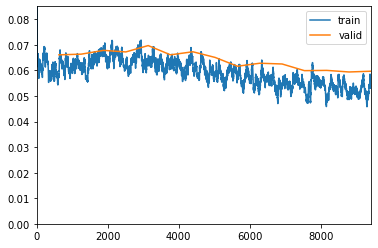

Epoch 2: reducing lr to 9.079514535047707e-06
Epoch 4: reducing lr to 9.699226010806377e-06
Epoch 6: reducing lr to 8.080078364531116e-06
Better model found at epoch 7 with valid_loss value: 0.06510517001152039.
Better model found at epoch 8 with valid_loss value: 0.06166195124387741.
Epoch 10: reducing lr to 2.810214672377973e-06
Better model found at epoch 11 with valid_loss value: 0.05993453040719032.
Better model found at epoch 13 with valid_loss value: 0.059414658695459366.


In [ ]:
cb_fit = [
    SaveModelCallback(fname="fastai-UNET-XResNeXt34-128x800-finetuning", with_opt=True),
    CSVLogger(fname='history-UNET-XResNeXt34-128x800-finetuning.csv', append=False)
]
segmentation_learner.fit_one_cycle(15, lr_max=slice(1e-5,1e-4), cbs=cb_fit)

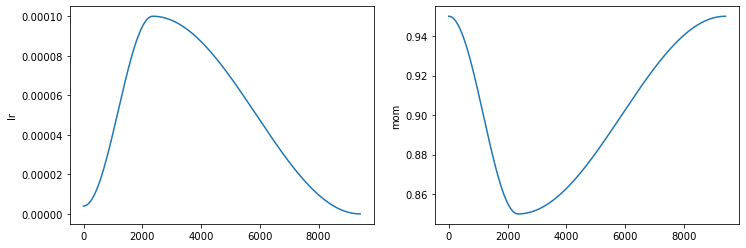

In [ ]:
segmentation_learner.recorder.plot_sched()

Training with `lovasz_softmax` after the fix, it needs the sigmoid before apply this loss func.

In [ ]:
segmentation_learner.loss_func = lovasz_softmax

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=6.309573450380412e-07)

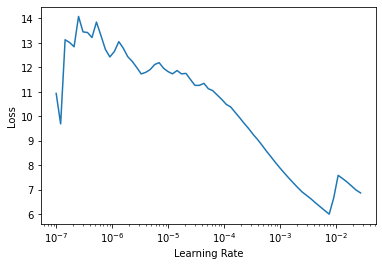

In [ ]:
segmentation_learner.lr_find()

epoch,train_loss,valid_loss,dice_multi,time
0,0.488388,0.449768,0.205847,13:17
1,0.411638,0.401386,0.242934,13:17
2,0.395849,0.387486,0.291508,13:18
3,0.385590,0.382098,0.303588,13:17
4,0.370500,0.371389,0.343426,13:18
5,0.366245,0.366175,0.391646,13:16
6,0.359125,0.366591,0.377490,13:16
7,0.368156,0.364070,0.416839,13:16
8,0.359795,0.363765,0.422323,13:16
9,0.360959,0.363431,0.423463,13:16


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


Better model found at epoch 0 with valid_loss value: 0.44976818561553955.


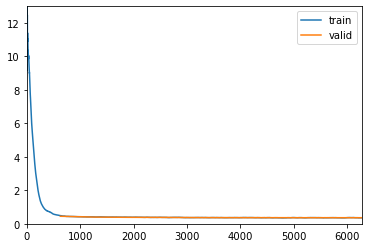

Better model found at epoch 1 with valid_loss value: 0.40138572454452515.
Better model found at epoch 2 with valid_loss value: 0.3874858021736145.
Better model found at epoch 3 with valid_loss value: 0.38209840655326843.
Better model found at epoch 4 with valid_loss value: 0.37138915061950684.
Better model found at epoch 5 with valid_loss value: 0.36617496609687805.
Better model found at epoch 7 with valid_loss value: 0.36407023668289185.
Better model found at epoch 8 with valid_loss value: 0.36376455426216125.
Better model found at epoch 9 with valid_loss value: 0.36343106627464294.


In [ ]:
cb_fit = [
    SaveModelCallback(fname="fastai-UNET-XResNeXt34-128x800-finetuning-lovloss", with_opt=True),
    CSVLogger(fname='history-UNET-XResNeXt34-128x800-lovloss.csv')
]

segmentation_learner.fit_one_cycle(n_epoch=10, lr_max=slice(3e-5,3e-4), cbs=cb_fit)

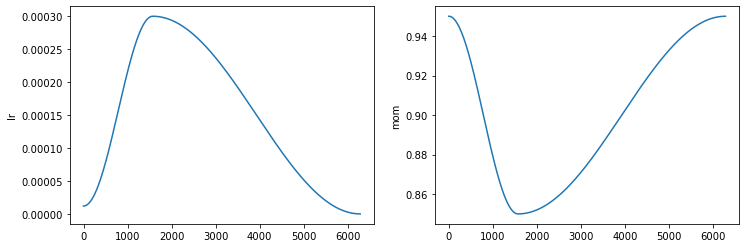

In [ ]:
segmentation_learner.recorder.plot_sched()

In [ ]:
segmentation_learner.freeze()

In [ ]:
segmentation_learner.show_results(figsize=(15,5))

## Full size

In [ ]:
bs = 4 # 16 gb
dls = get_segmentation_dls(bs, size=(256, 1600))

In [ ]:
cbs = [
    ShowGraphCallback(), 
    GradientAccumulation(n_acc=32)
]
segmentation_learner = unet_learner(
    dls=dls, 
    arch=arch, 
    #loss_func=lovasz_softmax,
    metrics=seg_metrics, 
    pretrained=True, 
    cbs=cbs,
    model_dir=models_dir
).to_fp16()

In [ ]:
segmentation_learner = segmentation_learner.load("fastai-UNET-XResNeXt34-128x800")

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


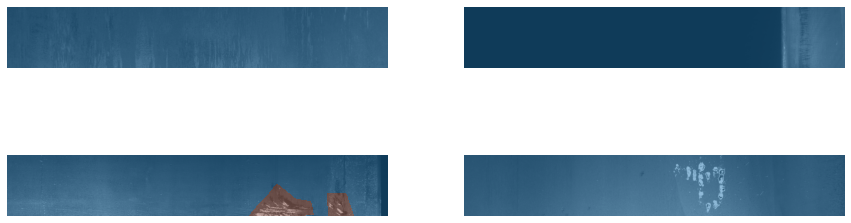

In [ ]:
segmentation_learner.dls.valid.show_batch(figsize=(15,5), ncols=2)

After training with BCE, train with another loss function ([discussion](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114297)).

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.9054607491852948e-06)

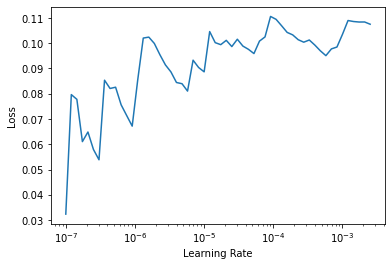

In [ ]:
segmentation_learner.lr_find()

In [ ]:
x,y = segmentation_learner.dls.one_batch()

In [ ]:
preds = segmentation_learner.model(x)

In [ ]:
x.shape, preds.shape, y.shape

(torch.Size([24, 3, 128, 800]),
 torch.Size([24, 5, 128, 800]),
 torch.Size([24, 128, 800]))

In [ ]:
segmentation_learner.loss_func??

In [ ]:
lovasz_softmax(preds, y)

TensorImage(14.6976, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
segmentation_learner.loss_func(preds, y)

TensorBase(0.0422, device='cuda:0', grad_fn=<AliasBackward>)